Install required libraries.



In [6]:
# save
import json
import os

path_data_file = "data/v4"

# Save global_embeddings to a JSON file
def save_json(data, filename):
    os.makedirs(path_data_file, exist_ok=True)
    with open(path_data_file + filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

#load
def load_json(filename):
    with open(path_data_file + filename, "r", encoding="utf-8") as f:
        return json.load(f)

In [4]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
#
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

embd = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)


C:\Users\Iranian\AppData\Local\Temp\ipykernel_9696\2378217556.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embd = HuggingFaceEmbeddings(
i:\AI_Project\manual_raptor\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tiktoken
import matplotlib.pyplot as plt

## Helper Fuction to count the number of Tokensin each text
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [4]:
from langchain.schema import Document


docs_texts = load_json("/docs_texts.json")

# Load from the JSON file
docs_data = load_json("/docs.json")
docs = [Document(page_content=doc["page_content"], metadata=doc["metadata"]) for doc in docs_data]


In [5]:
print(len(docs_texts))
print(len(docs))

35
35


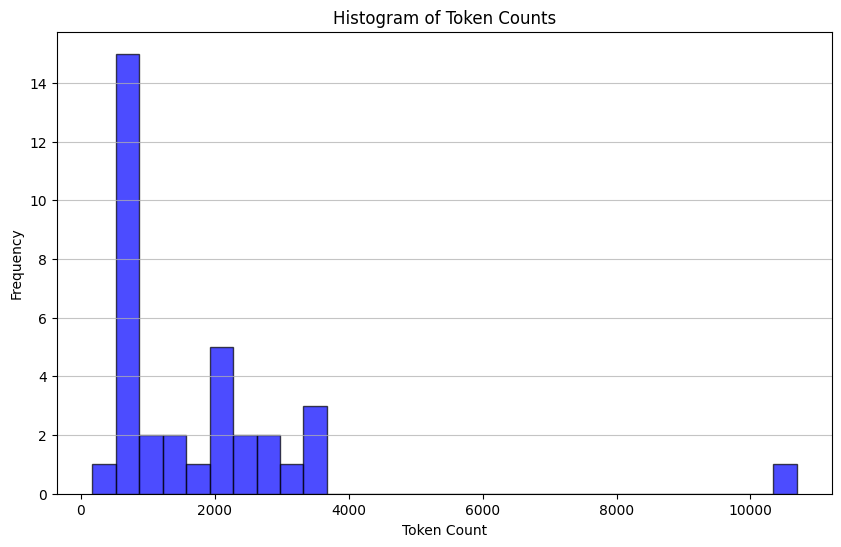

In [6]:
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

In [7]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 63322


In [1]:
concatenated_content = open("data/v4/data3.txt", "r", encoding="utf-8").read()

In [2]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 1000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)
#
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 98


In [5]:
global_embeddings = [embd.embed_query(txt) for txt in texts_split]
print(len(global_embeddings[0]))
save_json(global_embeddings, "/global_embeddings.json")


384


NameError: name 'save_json' is not defined

In [7]:
save_json(global_embeddings, "/global_embeddings.json")

i:\AI_Project\manual_raptor\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[ 8.241252 10.93297 ]


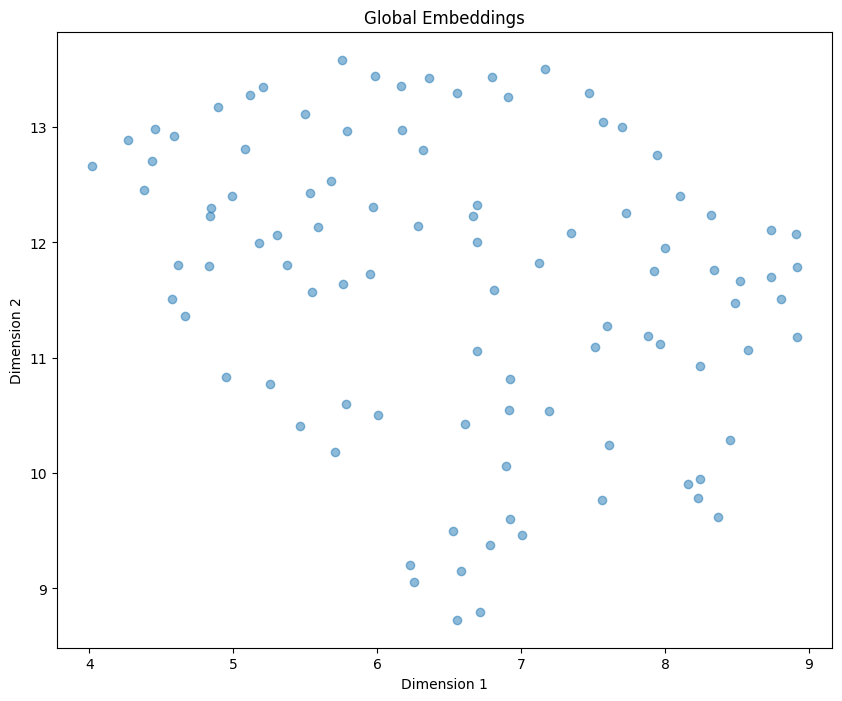

In [8]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
print(global_embeddings_reduced[0])
#
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

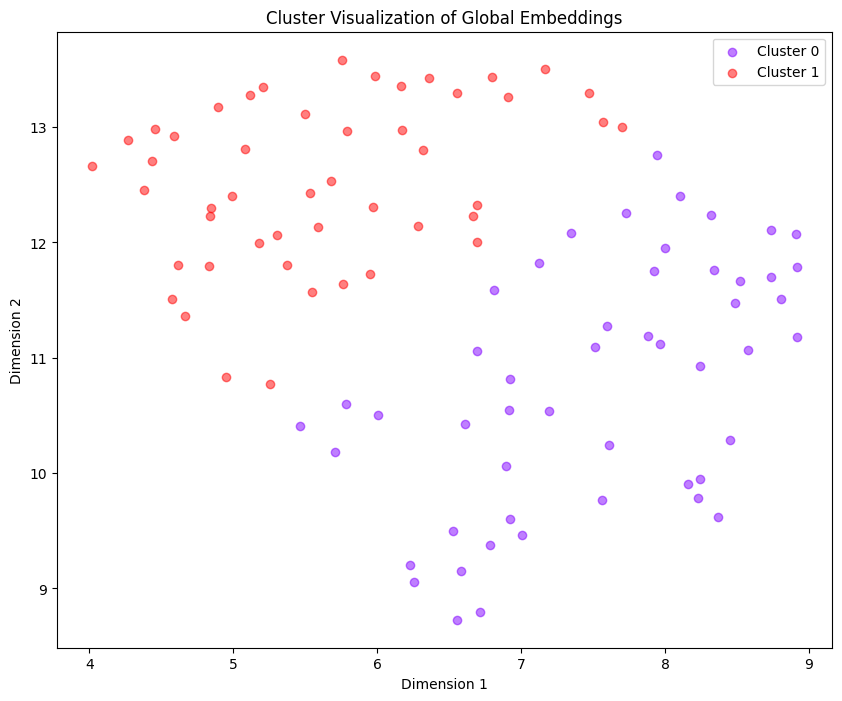

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters
#
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [11]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text               Embedding  \
0  ایرالکو برنده اصلی اختلافات خانوادگی؛ مقاومت ح...    [8.241252, 10.93297]   
1  چهارمین باخت نساجی طی دو فصل \nآلومینیوم با مج...  [4.6665916, 11.366106]   
2  آلومینیوم برنده اصلی جدال درون‌خانوادگی \nپس ا...   [5.983733, 13.441694]   

   Cluster  
0        0  
1        1  
2        1  


In [12]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts
#
clustered_texts = format_cluster_texts(df)
#
clustered_texts

{0: 'ایرالکو برنده اصلی اختلافات خانوادگی؛ مقاومت حسینی مقابل پرسپولیس بی\u200cدلیل نبود\n09 بهمن 1403 ساعت 09:00\n9 نظر\nایرالکو برنده اصلی اختلافات خانوادگی؛ مقاومت حسینی مقابل پرسپولیس بی\u200cدلیل نبود\nنساجی\nنساجی\n1 - 2\nپایان\nآلومینیوم اراک\nآلومینیوم اراک\nروز سوم هفته هفدهم رقابت\u200cهای لیگ بیست\u200cو\u200cچهام به کام مجتبی حسینی و شاگردانش بود.\nبه گزارش فوتبال 360، مجتبی حسینی در حال سپری کردن دوران خوشی با آلومینیوم است. او طی ای سال\u200cها در ذوب\u200cآهن و پیکان سختی\u200cهای زیادی متحمل شد و با مدیران باشگاه اختلاف داشت اما در اراک تیم منسجمی ساخته که نبرد با آن\u200cها برای هر حریفی سخت است. البته گاهی اختلاف نظراتی هم با رجاییان و هیات\u200cمدیره دارد ولی شکاف میان کادر فنی و مدیریت آنچنان نیست که کار تیم را مختل کند. آن\u200cها هفته هفدهم را با یک پیروزی ارزشمند در ورزشگاه وطنی قائمشهر پشت سر گذاشتند و بار دیگر رد پای امین کاظمیان ستاره این فصل لیگ برتر در این برد محسوس بود. --- ایرالکو به دنبال صدرنشینی در لیگ میانه جدولی\u200cها \nمعمولا مربیان تیم\u200cهای می